# Binance Future（先物） CCXTの基本操作まとめ


In [20]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import ccxt

#CCXTを使ったBinance先物のAPI設定
binance = ccxt.binance({"apiKey":"○○○○○○○○○○○○○○○○○○○○○○○○○",  #apiKeyを入力
                         "secret":"○○○○○○○○○○○○○○○○○○○○○○○○",  #secretKeyを入力
                         "options": {"defaultType": "future"},
                         "enableRateLimit": True})

ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

### 特定の銘柄のOHLCV情報を数本だけ取得する

例としてXRPUSDTの1時間足のOHLCV情報を直近200本だけ取得して表示

In [21]:
#Binanceでの特定の銘柄のOHLCV情報を取得
def get_binance_ohlcv(symbol,from_time,interval_sec,limit):
    ohlcv_list = ccxt.binance().fapiPublicGetKlines({
        "symbol": symbol,
        "startTime": from_time,
        "interval": format_interval_sec(interval_sec),
        "limit": limit
    })

    df = pd.DataFrame(ohlcv_list,columns=['timestamp',
                'op',
                'hi',
                'lo',
                'cl',
                'volume',
                'close_time',
                'quote_asset_volume',
                'trades',
                'taker_buy_base_asset_volume',
                'taker_buy_quote_asset_volume',
                'ignore',]) [['timestamp', 'op', 'hi', 'lo', 'cl', 'volume']]

    df = df[from_time <= df['timestamp'].astype('int64')]
    df['timestamp'] = pd.to_datetime(df['timestamp'] , unit='ms')
    df.set_index("timestamp",inplace=True)
    df["op"]=df["op"].astype(float)
    df["hi"]=df["hi"].astype(float)
    df["lo"]=df["lo"].astype(float)
    df["cl"]=df["cl"].astype(float)
    df["volume"]=df["volume"].astype(float)
    df.sort_index(inplace=True)
    return df

def format_interval_sec(interval_sec):
    interval_min = interval_sec // 60
    if interval_min < 60:
        return '{}m'.format(interval_min)
    if interval_min < 24 * 60:
        return '{}h'.format(interval_min // 60)
    else:
        return '{}d'.format(interval_min // (24 * 60))
    

#例としてXRPの1時間足のOHLCV情報を直近200本だけ取得
interval_sec = 60*60  #1時間足 
time_now = datetime.now()
from_time = int((time_now + timedelta(minutes= - 100000 * interval_sec)).timestamp())
limit = 200 #200本だけ取得
ohlcv_XRP = "XRPUSDT"
df_XRP = get_binance_ohlcv(ohlcv_XRP,from_time,interval_sec,limit)

print(df_XRP)

                         op      hi      lo      cl      volume
timestamp                                                      
2022-03-20 23:00:00  0.8091  0.8091  0.8041  0.8052  11515970.9
2022-03-21 00:00:00  0.8053  0.8068  0.8011  0.8064  15843287.2
2022-03-21 01:00:00  0.8065  0.8083  0.8028  0.8047  11676367.5
2022-03-21 02:00:00  0.8048  0.8059  0.7860  0.7939  50019457.8
2022-03-21 03:00:00  0.7939  0.7994  0.7929  0.7985  16352723.7
...                     ...     ...     ...     ...         ...
2022-03-29 02:00:00  0.8782  0.8786  0.8698  0.8700  18384295.6
2022-03-29 03:00:00  0.8700  0.8740  0.8696  0.8710  14022715.1
2022-03-29 04:00:00  0.8711  0.8775  0.8681  0.8769  18606726.7
2022-03-29 05:00:00  0.8769  0.8839  0.8766  0.8827  24697470.2
2022-03-29 06:00:00  0.8827  0.8854  0.8812  0.8840   9944796.8

[200 rows x 5 columns]


ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

### 特定の銘柄のポジション情報を取得する

例としてXRPUSDTのポジション情報を取得して表示

In [22]:
#特定の銘柄のポジション情報を取得する関数
def get_binance_position(binance,searchSymbol):
    position = binance.fapiPrivateGetPositionRisk() #全銘柄のポジション情報を取得
    #print(position)

    onlySymbolName = [d.get("symbol") for d in position]  #沢山の辞書データから銘柄の名称だけを順番に抽出
    #print(onlySymbolName)
    
    searchSymbol_index = onlySymbolName.index(searchSymbol) #知りたい銘柄のポジション情報が何番目の辞書に存在するかを特定
    #print("\n{0}のポジション情報は{1}番目に存在".format(str(searchSymbol),str(searchSymbol_index)))
    print("\n現在の{0}のポシジョン情報↓↓↓\n{1}".format(str(searchSymbol),str(position[searchSymbol_index]))) #知りたい銘柄だけの詳細なポジション情報を取得

    positionAmt = float(position[searchSymbol_index]["positionAmt"]) #知りたい銘柄のポジションサイズを抽出
    positionSide = str(position[searchSymbol_index]["positionSide"]) #知りたい銘柄のポジションサイドを抽出

    if positionAmt == 0:
        positionSide = "NONE" #ポジションを持ってない時、デフォだとBOTHになってしまい分かりづらいのでNONEに変更
    elif positionAmt > 0:
        positionSide = "BUY"
    else:
        positionSide = "SELL"
    return {"positionSide":positionSide, "positionAmt":positionAmt}


#例としてXRPUSDTのポジション情報を取得する
searchSymbol = "XRPUSDT"
position_XRP = get_binance_position(binance, searchSymbol)

#例:ポジションサイドとポジションサイズだけをそれぞれ取得したい場合
print("\n現在の{0}のポジションサイド:{1}".format(str(searchSymbol),str(position_XRP["positionSide"])))
print("現在の{0}のポジションサイズ:{1}".format(str(searchSymbol),str(position_XRP["positionAmt"])))


現在のXRPUSDTのポシジョン情報↓↓↓
{'symbol': 'XRPUSDT', 'positionAmt': '0.0', 'entryPrice': '0.0', 'markPrice': '0.88420000', 'unRealizedProfit': '0.00000000', 'liquidationPrice': '0', 'leverage': '6', 'maxNotionalValue': '1000000', 'marginType': 'isolated', 'isolatedMargin': '0.00000000', 'isAutoAddMargin': 'false', 'positionSide': 'BOTH', 'notional': '0', 'isolatedWallet': '0', 'updateTime': '0'}

現在のXRPUSDTのポジションサイド:NONE
現在のXRPUSDTのポジションサイズ:0.0


ーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーーー

### Binanceへ注文する（成行）


In [23]:
#Binanceへ注文する関数
def order_binance(binance,symbol,order_side,order_size):
    order = binance.fapiPrivate_post_order(
        {
            "symbol": symbol,
            "side": order_side,
            "type": "MARKET",
            "quantity": order_size,
        }
    )
    print(order)

In [26]:
# 例: XRPUSDTを成行で10枚分ロングエントリー
# ※実行すると注文されてしまうので注意！

#ロングエントリー
symbol = "XRPUSDT"
order_side = "BUY" #ショートエントリーなら"SELL"
order_size = 10.0
order_binance(binance,symbol,order_side,order_size)

{'orderId': '20530378987', 'symbol': 'XRPUSDT', 'status': 'NEW', 'clientOrderId': 'J8u8kUIpxn5zXM41QZGzEq', 'price': '0', 'avgPrice': '0.00000', 'origQty': '10', 'executedQty': '0', 'cumQty': '0', 'cumQuote': '0', 'timeInForce': 'GTC', 'type': 'MARKET', 'reduceOnly': False, 'closePosition': False, 'side': 'BUY', 'positionSide': 'BOTH', 'stopPrice': '0', 'workingType': 'CONTRACT_PRICE', 'priceProtect': False, 'origType': 'MARKET', 'updateTime': '1648535340054'}


## 実際に注文されるとこの画像のようになります。

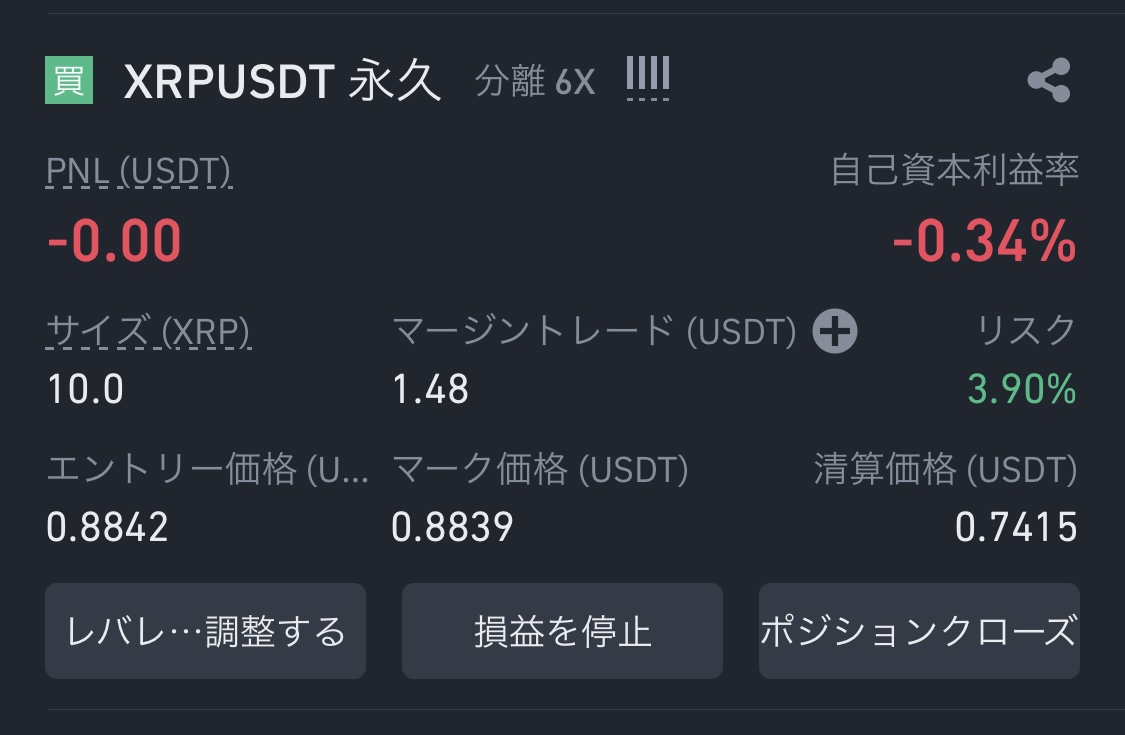

In [27]:
# 例：XRPUSDTを成行で全枚数ロングクローズ
# ※実行すると注文されてしまうので注意！

#XRPUSDTのポジション情報を取得する
position_XRP = get_binance_position(binance, symbol)

#ロングクローズ
order_side = "SELL" #ロングクローズなら"SELL"
order_size = abs(position_XRP["positionAmt"])
order_binance(binance,symbol,order_side,order_size)


現在のXRPUSDTのポシジョン情報↓↓↓
{'symbol': 'XRPUSDT', 'positionAmt': '10.0', 'entryPrice': '0.8842', 'markPrice': '0.88420690', 'unRealizedProfit': '0.00006900', 'liquidationPrice': '0.74150825', 'leverage': '6', 'maxNotionalValue': '1000000', 'marginType': 'isolated', 'isolatedMargin': '1.47518449', 'isAutoAddMargin': 'false', 'positionSide': 'BOTH', 'notional': '8.84206900', 'isolatedWallet': '1.47511549', 'updateTime': '1648535340054'}
{'orderId': '20530425752', 'symbol': 'XRPUSDT', 'status': 'NEW', 'clientOrderId': 'ZkXQ1tW3mxAilxE9WH6y35', 'price': '0', 'avgPrice': '0.00000', 'origQty': '10', 'executedQty': '0', 'cumQty': '0', 'cumQuote': '0', 'timeInForce': 'GTC', 'type': 'MARKET', 'reduceOnly': False, 'closePosition': False, 'side': 'SELL', 'positionSide': 'BOTH', 'stopPrice': '0', 'workingType': 'CONTRACT_PRICE', 'priceProtect': False, 'origType': 'MARKET', 'updateTime': '1648535562158'}
